In [2]:
# Restart runtime using 'Runtime' -> 'Restart runtime...'
#%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

/home/guillermogarcia/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/guillermogarcia/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/guillermogarcia/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/guillermogarcia/anaconda3/lib/python3.7/site-pack

1.14.0


/home/guillermogarcia/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/guillermogarcia/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/guillermogarcia/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/guillermogarcia/anaconda3/li

In [ ]:
import numpy as np
np.random.seed(1337)  # for reproducibility

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.optimizers import SGD, RMSprop
from keras import backend as K
from matplotlib import pyplot as plt

class DataGenerator(object):
    """docstring for DataGenerator"""
    def __init__(self, batch_sz):
        # the data, shuffled and split between train and test sets
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
        X_train = X_train.reshape(60000, 784)
        X_test = X_test.reshape(10000, 784)
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')
        X_train /= 255
        X_test /= 255
        
        # create training+test positive and negative pairs
        digit_indices = [np.where(y_train == i)[0] for i in range(10)]
        self.tr_pairs, self.tr_y = self.create_pairs(X_train, digit_indices) 
        digit_indices = [np.where(y_test == i)[0] for i in range(10)]
        self.te_pairs, self.te_y = self.create_pairs(X_test, digit_indices)
        
        #print((self.tr_pairs).shape)

        

        self.tr_pairs_0 = self.tr_pairs[:, 0]   #(108400,784)
        self.tr_pairs_1 = self.tr_pairs[:, 1]
        self.te_pairs_0 = self.te_pairs[:, 0]
        self.te_pairs_1 = self.te_pairs[:, 1]
        

        #print((self.tr_pairs_0).shape)
        
        self.batch_sz = batch_sz
        self.samples_per_train  = (self.tr_pairs.shape[0]/self.batch_sz)*self.batch_sz
        self.samples_per_val    = (self.te_pairs.shape[0]/self.batch_sz)*self.batch_sz
        
        
        self.cur_train_index = 0
        self.cur_val_index = 0
        
        
    def create_pairs(self, x, digit_indices):
        '''Positive and negative pair creation.
        Alternates between positive and negative pairs.
        '''
        pairs = []
        labels = []
        n = min([len(digit_indices[d]) for d in range(10)]) - 1
        for d in range(10):
            for i in range(n):
                z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
                pairs += [[x[z1], x[z2]]]
                inc = random.randrange(1, 10)
                dn = (d + inc) % 10
                z1, z2 = digit_indices[d][i], digit_indices[dn][i]
                pairs += [[x[z1], x[z2]]]
                labels += [1, 0]
        return np.array(pairs), np.array(labels)

      
    #Estas funciones es como si cargara solo un batch cada vez.  
      
    def next_train(self):
        while 1:
            self.cur_train_index += self.batch_sz              #Va aumentando el indice de lo que coges, para ir cogiendo hasta que coges todas las imagenes
            if self.cur_train_index >= self.samples_per_train:
                self.cur_train_index=0
            yield ([    self.tr_pairs_0[self.cur_train_index:self.cur_train_index+self.batch_sz], 
                        self.tr_pairs_1[self.cur_train_index:self.cur_train_index+self.batch_sz]
                    ],                                                                                 #Cuando llega vuelve a poner self.tr_pairs_0 a coger un barch (0,128) /// (128,784)
                   
                        self.tr_y[self.cur_train_index:self.cur_train_index+self.batch_sz]
                )

    def next_val(self):
        while 1:
            self.cur_val_index += self.batch_sz
            if self.cur_val_index >= self.samples_per_val:
                self.cur_val_index=0
            yield ([    self.te_pairs_0[self.cur_val_index:self.cur_val_index+self.batch_sz], 
                        self.te_pairs_1[self.cur_val_index:self.cur_val_index+self.batch_sz]
                    ],
                    self.te_y[self.cur_val_index:self.cur_val_index+self.batch_sz]
                )

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(128, input_shape=(input_dim,), activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(128, activation='relu'))
    return seq


def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()



input_dim = 784
nb_epoch = 1
batch_size=128

datagen = DataGenerator(batch_size)

# network definition
base_network = create_base_network(input_dim)

input_a = Input(shape=(input_dim,))
input_b = Input(shape=(input_dim,))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)


#for i in datagen.next_train():
#  print(i)



#for i in datagen.next_train():
#  for j in i:
#    print(np.array(j).shape)


distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(input=[input_a, input_b], output=distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)
history = model.fit_generator(generator=datagen.next_train(), samples_per_epoch=datagen.samples_per_train, nb_epoch=nb_epoch, validation_data=datagen.next_val(), nb_val_samples=datagen.samples_per_val)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.metrics_names


Using TensorFlow backend.


11493376/11490434 [==============================] - 3s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/guillermogarcia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:163: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
/home/guillermogarcia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:168: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/guillermogarcia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:168: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., validation_data=<generator..., steps_per_epoch=108400.0, epochs=1, validation_steps=17820.0)`



Epoch 1/1
  3874/108400 [>.............................] - ETA: 9:53 - loss: nan

TypeError: ignored

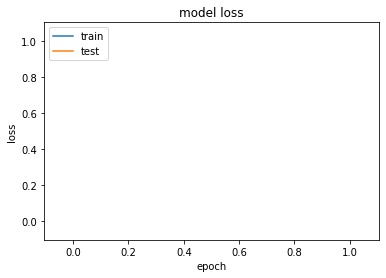

In [7]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
